In [1]:
import os

curr_folder = os.getcwd() + "/"
datasets_folder = curr_folder[:-6] + "Datasets/"
stats_results_folder = curr_folder + "Results/"
print(datasets_folder)
print(stats_results_folder)

/home/ipsilva/Repositories/dynamic-projections/Datasets/
/home/ipsilva/Repositories/dynamic-projections/Stats/Results/


In [2]:
datasets_subfolders = []
for i in os.walk(datasets_folder):
    datasets_subfolders.append(i[0])

datasets_subfolders = datasets_subfolders[1:]
datasets_subfolders

['/home/ipsilva/Repositories/dynamic-projections/Datasets/gaussians',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/quickdraw',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/sorts',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/walk',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/nnset',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/fashion',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/cifar10cnn',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/esc50',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/qtables',
 '/home/ipsilva/Repositories/dynamic-projections/Datasets/cartolastd']

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

def intrisic_dim(dataframe, target_variance):
    dataframe = StandardScaler().fit_transform(dataframe)
    pca = PCA()

    principalComponents = pca.fit_transform(dataframe)

    list_variance = pca.explained_variance_ratio_

    final_var = 0
    dims = 0
    for var in list_variance:
        final_var += var
        dims += 1
        if final_var > target_variance:
            break
    return dims, final_var, principalComponents[:dims]

In [314]:
from os.path import isfile, join
from itertools import product
from os import listdir
import pandas as pd
import numpy as np
import cv2
import re

def collect_one_info(dataset_loc, target_variance=0.9, drop_first_column=True):
    files = [f for f in listdir(dataset_loc) if isfile(join(dataset_loc, f))]
    
    try:
        df = pd.DataFrame()
        obs_per_timestep = []
        for file in files:
            file_loc = dataset_loc + "/" + file
            ndf = pd.read_csv(file_loc)
            df = df.append(ndf, sort=False)
            obs_per_timestep.append(ndf.shape[0])

            median_obs_per_timestep = np.median(obs_per_timestep)
            dev_obs_per_timestep = np.std(obs_per_timestep)

        if drop_first_column:
            df = df.drop(columns=df.columns[0], axis=1)

        (intrinsic_dims, final_variance, components) = intrisic_dim(df, target_variance)
    except:
        images_as_lines = []
        obs_per_timestep = {}
        for file in files:
            file_loc = dataset_loc + "/" + file
            image = cv2.imread(file_loc)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

            line = gray.reshape(-1)
            images_as_lines.append(line)

            time = re.search("[0-9]+.png$", file).group()
            try:
                obs_per_timestep[time] == False
                obs_per_timestep[time] += 1
            except:
                obs_per_timestep[time] = 1

        obs_per_timestep = list(obs_per_timestep.values())
        median_obs_per_timestep = np.median(obs_per_timestep)
        dev_obs_per_timestep = np.std(obs_per_timestep)

        (i,j) = gray.shape
        i_l = [i_e for i_e in range(i)]
        j_l = [j_e for j_e in range(j)]
        columns = list(product(i_l, j_l))        
        df = pd.DataFrame(images_as_lines, columns=columns)
        
        (intrinsic_dims, final_variance, components) = intrisic_dim(df, target_variance)

    total_regs = df.shape[0]
    total_dims = df.shape[1]
    total_timesteps = len(obs_per_timestep)
    component_dims = components.shape
    return (total_regs, total_timesteps, median_obs_per_timestep, dev_obs_per_timestep, total_dims, intrinsic_dims, final_variance, component_dims, components)

def collect_info_list(dataset_locations, target_variance=0.9, return_components=False, drop_first_column=True):
    """
        Input: 
            dataset_locations: a list of directories where to find the data files (csv or png files)
            target_variance: value between [0,1] which will be used to return the necessary number of PCA components to explain the given variance value
            return_components: boolean. Returns the PCA components if True
            drop_first_column: boolean. Used to drop the first column, normally used for the register naming
            
            Important: all the columns must be numeric to apply the PCA algorithm
        
        Output: a list of dictionary containing the information about the given datasets
            filename: the name of the dataset
            total_registers: number of rows in the dataset, accumulated through timesteps
            total_timesteps: number of time revisions of the dataset
            median_obs_per_timestep: median of the number of registers per timestep
            dev_obs_per_timestep: standard deviation of the number of registers per timestep
            total_dims: number of dimensions of the dataset
            intrinsic_dims: number of dimensions needed to explain the given target_variance
            final_variance: the variance explained by the intrinsic_dims PCA components
            component_dims: the shape of the components item in the tuple (only if return_components is True)
            components: the returned components calculated by the PCA algorithm (only if return_components is True)            
    """
    
    total_datasets = len(dataset_locations)
    results = []
    for i, dataset in enumerate(dataset_locations):
        filename = dataset.split('/')[-1]
        print("Dataset {0}/{1}: {2}".format(i+1, total_datasets, filename))
        if return_components:
            (total_regs, total_timesteps, median_obs_per_timestep, dev_obs_per_timestep, total_dims, intrinsic_dims, final_variance, component_dims, components) = collect_one_info(dataset, target_variance)
            result = dict()
            result['filename'] = filename
            result['total_registers'] = total_regs
            result['total_timesteps'] = total_timesteps
            result['median_obs_per_timestep'] = median_obs_per_timestep
            result['dev_obs_per_timestep'] = dev_obs_per_timestep
            result['total_dims'] = total_dims
            result['intrinsic_dims'] = intrinsic_dims
            result['final_variance'] = final_variance
            result['component_dims'] = component_dims
            result['components'] = components
            results.append(result)
        else:
            total_regs, total_timesteps, median_obs_per_timestep, dev_obs_per_timestep, total_dims, intrinsic_dims, final_variance, _, _ = collect_one_info(dataset, target_variance)
            result = dict()
            result['filename'] = filename
            result['total_registers'] = total_regs
            result['total_timesteps'] = total_timesteps
            result['median_obs_per_timestep'] = median_obs_per_timestep
            result['dev_obs_per_timestep'] = dev_obs_per_timestep
            result['total_dims'] = total_dims
            result['intrinsic_dims'] = intrinsic_dims
            result['final_variance'] = final_variance
            results.append(result)
            
    return results

In [315]:
infos = np.array(collect_info_list(datasets_subfolders))

Dataset 1/10: gaussians
Dataset 2/10: quickdraw
Dataset 3/10: sorts
Dataset 4/10: walk
Dataset 5/10: nnset
Dataset 6/10: fashion
Dataset 7/10: cifar10cnn
Dataset 8/10: esc50
Dataset 9/10: qtables
Dataset 10/10: cartolastd


In [316]:
infos

array([{'final_variance': 0.9000354144670784, 'intrinsic_dims': 85, 'total_timesteps': 10, 'filename': 'gaussians', 'median_obs_per_timestep': 2000.0, 'total_registers': 20000, 'total_dims': 100, 'dev_obs_per_timestep': 0.0},
       {'final_variance': 0.9004783755811413, 'intrinsic_dims': 356, 'total_timesteps': 89, 'filename': 'quickdraw', 'median_obs_per_timestep': 130.0, 'total_registers': 21670, 'total_dims': 784, 'dev_obs_per_timestep': 243.3966159117527},
       {'final_variance': 0.9022625625133, 'intrinsic_dims': 62, 'total_timesteps': 98, 'filename': 'sorts', 'median_obs_per_timestep': 80.0, 'total_registers': 7840, 'total_dims': 100, 'dev_obs_per_timestep': 0.0},
       {'final_variance': 0.9023431243452701, 'intrinsic_dims': 30, 'total_timesteps': 50, 'filename': 'walk', 'median_obs_per_timestep': 300.0, 'total_registers': 15000, 'total_dims': 100, 'dev_obs_per_timestep': 0.0},
       {'final_variance': 0.9006497658928339, 'intrinsic_dims': 180, 'total_timesteps': 30, 'filen

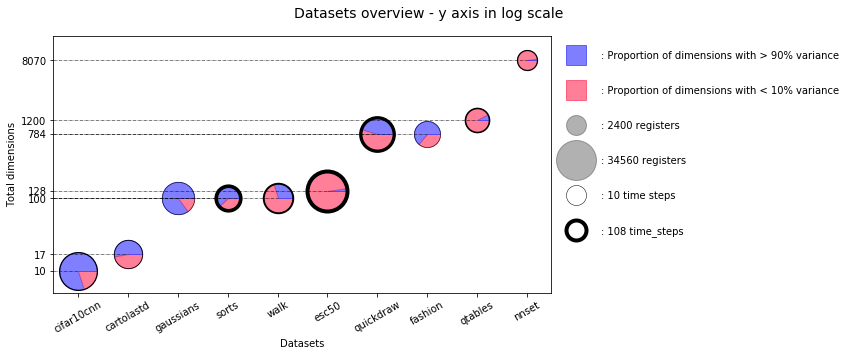

In [350]:
from matplotlib.lines import Line2D
from matplotlib.patches import Circle
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
import math

# Ordering by total number of dimensions
dimensions = np.array([info['total_dims'] for info in infos])
ordered_idx = np.argsort(dimensions)
infos = np.array(infos)[ordered_idx]

timesteps_list = [info['total_timesteps'] for info in infos]
min_timesteps, max_timesteps = min(timesteps_list), max(timesteps_list)
min_size = 20**2
max_size = 40**2

num_register_list = [info['total_registers'] for info in infos]
min_registers, max_registers = min(num_register_list), max(num_register_list)
min_border = 0.5
max_border = 4 #2

timesteps_to_size_ratio = (max_size-min_size)/(max_timesteps-min_timesteps)
timesteps_to_border_ratio = (max_border-min_border)/(max_timesteps-min_timesteps)
reg_to_size_ratio = (max_size-min_size)/(max_registers-min_registers)
reg_to_border_ratio = (max_border-min_border)/(max_registers-min_registers)

greater_variance_color = [0,0,1,0.5]
complementary_variance_color = [1,0,0.2,0.5]

fig, ax = plt.subplots(1,1, figsize=(12,5))

yticks = []
min_x, max_x = 99, 0
min_y, max_y = 99, 0

for info in infos:
    filename = info['filename']
    total_dims = info['total_dims']
    yticks.append(total_dims)
    ratio_intrinsic_dim = info['intrinsic_dims']/total_dims

#     size = (info['total_timesteps']-min_timesteps)*timesteps_to_size_ratio + min_size
#     border = (info['total_registers']-min_registers)*reg_to_border_ratio + min_border
    size = (info['total_registers']-min_registers)*reg_to_size_ratio + min_size
    border = (info['total_timesteps']-min_timesteps)*timesteps_to_border_ratio + min_border
    
    x = [0] + np.cos(np.linspace(0, 2 * np.pi * ratio_intrinsic_dim, 20)).tolist()
    y = [0] + np.sin(np.linspace(0, 2 * np.pi * ratio_intrinsic_dim, 20)).tolist()
    xy_instrinsic_dim = np.column_stack([x, y])
    tmp_min_x, tmp_max_x = min(x), max(x)
    tmp_min_y, tmp_max_y = min(y), max(y)
    if tmp_min_x < min_x:
        min_x = tmp_min_x
    if tmp_max_x > max_x:
        max_x = tmp_max_x
    if tmp_min_y < min_y:
        min_y = tmp_min_y
    if tmp_max_y > max_y:
        max_y = tmp_max_y
        
    x = [0] + np.cos(np.linspace(2 * np.pi * ratio_intrinsic_dim, 2 * np.pi, 20)).tolist()
    y = [0] + np.sin(np.linspace(2 * np.pi * ratio_intrinsic_dim, 2 * np.pi, 20)).tolist()
    xy_total_dim = np.column_stack([x, y])
    tmp_min_x, tmp_max_x = min(x), max(x)
    tmp_min_y, tmp_max_y = total_dims+min(y), total_dims+max(y)
    if tmp_min_x < min_x:
        min_x = tmp_min_x
    if tmp_max_x > max_x:
        max_x = tmp_max_x
    if tmp_min_y < min_y:
        min_y = tmp_min_y
    if tmp_max_y > max_y:
        max_y = tmp_max_y
        
    ax.scatter([filename], total_dims, marker=xy_total_dim,
               s=size, c=[complementary_variance_color])
    ax.scatter([filename], total_dims, marker=xy_instrinsic_dim,
               s=size, c=[greater_variance_color])
    ax.scatter([filename], total_dims, marker='o', s=size, c=[[0,0,0,0]], edgecolor=[0,0,0,1], linewidths=border)

plt.tick_params(axis='y', which='minor', left=False)
plt.tick_params(axis='y', which='major', labelsize=10)

plt.yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_ticks(list(set(yticks)))

legend_elements = (Line2D([0], [0], marker='s', color=greater_variance_color, lw=0, markersize=20, label=': Proportion of dimensions with > 90% variance'),
                   Line2D([0], [0], marker='s', color=complementary_variance_color, lw=0, markersize=20, label=': Proportion of dimensions with < 10% variance'),
#                    Line2D([0], [0], marker='o', color=[0,0,0,0.3], lw=0, markersize=math.sqrt(min_size), label=': {0} time steps'.format(min_timesteps)),
#                    Line2D([0], [0], marker='o', color=[0,0,0,0.3], lw=0, markersize=math.sqrt(max_size), label=': {0} time steps'.format(max_timesteps)),
#                    Line2D([0], [0], marker='o', color=[1,1,1,0.3], markeredgewidth=min_border, markeredgecolor=[0,0,0,1], lw=0, markersize=math.sqrt(min_size), label=': {0} registers'.format(min_registers)),
#                    Line2D([0], [0], marker='o', color=[1,1,1,0.3], markeredgewidth=max_border, markeredgecolor=[0,0,0,1], lw=0, markersize=math.sqrt(min_size), label=': {0} registers'.format(max_registers)),
                   Line2D([0], [0], marker='o', color=[0,0,0,0.3], lw=0, markersize=math.sqrt(min_size), label=': {0} registers'.format(min_registers)),
                   Line2D([0], [0], marker='o', color=[0,0,0,0.3], lw=0, markersize=math.sqrt(max_size), label=': {0} registers'.format(max_registers)),
                   Line2D([0], [0], marker='o', color=[1,1,1,0.3], markeredgewidth=min_border, markeredgecolor=[0,0,0,1], lw=0, markersize=math.sqrt(min_size), label=': {0} time steps'.format(min_timesteps)),
                   Line2D([0], [0], marker='o', color=[1,1,1,0.3], markeredgewidth=max_border, markeredgecolor=[0,0,0,1], lw=0, markersize=math.sqrt(min_size), label=': {0} time_steps'.format(max_timesteps))
                  )
leg = ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), handletextpad=1.5, borderpad=1, labelspacing=2.5)
leg.get_frame().set_linewidth(0.0)

ax.set_ylabel('Total dimensions')
ax.set_xlabel('Datasets')

lim_x = ax.set_xlim(infos[0]['filename'], infos[-1]['filename'])
lim_x = ax.set_xlim(lim_x[0]-0.5, lim_x[1]+0.5)
lim_y = ax.set_ylim(float(10**0.7), float(10**4.25))

for info in infos:
    ax.hlines([info['total_dims']], lim_x[0], info['filename'], linestyle='-.', lw=.5)
#     ax.vlines([info['filename']], lim_y[0], info['total_dims'], linestyle='-.', lw=.5)

plt.xticks(rotation=30)

plt.suptitle("Datasets overview - y axis in log scale", fontsize=14, weight='roman')
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.savefig(stats_results_folder+"/datasets_overview_2_1")